<a href="https://colab.research.google.com/github/ramiltaief/Foot_Pred/blob/master/foot_prediction_PRJT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up the environment (Spark too)**

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.crihan.fr/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
#Test to see if it works

df = spark.createDataFrame([{"hello": "world"} for x in range(5)])
df.show(5)

+-----+
|hello|
+-----+
|world|
|world|
|world|
|world|
|world|
+-----+



In [ ]:
!unzip DATA.zip

Archive:  DATA.zip
replace DATA/Final-Results/Predicted_Result_withFix.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: DATA/Final-Results/Predicted_Result_withFix.csv  
  inflating: DATA/Fixtures/fixtures.csv  
  inflating: DATA/Pre-processed-data/all-season.csv  
  inflating: DATA/Season-stats/season-0910.csv  
  inflating: DATA/Season-stats/season-1011.csv  
  inflating: DATA/Season-stats/season-1112.csv  
  inflating: DATA/Season-stats/season-1213.csv  
  inflating: DATA/Season-stats/season-1314.csv  
  inflating: DATA/Season-stats/season-1415.csv  
  inflating: DATA/Season-stats/season-1516.csv  
  inflating: DATA/Season-stats/season-1617.csv  
  inflating: DATA/Season-stats/season-1718.csv  
  inflating: DATA/Season-stats/season-1819.csv  
  inflating: DATA/Teams/Teams.csv    


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display
import seaborn as sns
import warnings
#import sasl
warnings.filterwarnings('ignore')
#from pyhive import hive

Hive provides access to the cluster data with an SQL type interface. We can use PyHive to query Hive

Hive table retreive (already concatenate data-set at the creation of hive table)  from Hive.
**Unfortunately we did not manage to finish it because the connection between our Notebook and the VM did not succeed. However, we still managed to create the table on Hive, load the Data and make some queries in the VM as you will see in our Report.**

In [ ]:
'''
connection = hive.connect("10.3.4.10", username="training",password='training',
                          port=22, auth='LDAP')
cursor = connection.cursor()
query = "SELECT * FROM foot2"
cursor.execute(query)

data=cursor.fetchall() #Get resultSet (all rows) from the cursor object

display(data.head())
'''

'\nconnection = hive.connect("10.3.4.10", username="training",password=\'training\',\n                          port=22, auth=\'LDAP\')\ncursor = connection.cursor()\nquery = "SELECT * FROM foot2"\ncursor.execute(query)\n\ndata=cursor.fetchall() #Get resultSet (all rows) from the cursor object\n\ndisplay(data.head())\n'

Seasons CSV files concatenation 

In [ ]:
from glob import glob

def concat(outfile = 'all-season.csv'): 
    filenames = glob('./DATA/Season-stats/season*.csv') #similar naming pattern 
    dataframes = []
    for files in filenames:
        dataframes.append(pd.read_csv(files))
    concatDF = pd.concat(dataframes, axis=0) #vertical concatenation
    concatDF.to_csv('./DATA/Pre-processed-data/'+ outfile, index = None) 
    
concat() 
   
data = pd.read_csv('./DATA/Pre-processed-data/all-season.csv')
display(data.head())


,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,16/08/14,Arsenal,Crystal Palace,2,1,H,1,1,D,J Moss,14,4,6,2,13,19,9,3,2,2,0,1
1,16/08/14,Leicester,Everton,2,2,D,1,2,A,M Jones,11,13,3,3,16,10,3,6,1,1,0,0
2,16/08/14,Man United,Swansea,1,2,A,0,1,A,M Dean,14,5,5,4,14,20,4,0,2,4,0,0
3,16/08/14,QPR,Hull,0,1,A,0,0,D,C Pawson,19,11,6,4,10,10,8,9,1,2,0,0
4,16/08/14,Stoke,Aston Villa,0,1,A,0,0,D,A Taylor,12,7,2,2,14,9,2,8,0,3,0,0


In [ ]:
read_team_names = pd.read_csv('./DATA/Season-stats/season-1819.csv')
display(read_team_names.head())

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,10/08/18,Man United,Leicester,2,1,H,1,0,H,A Marriner,8,13,6,4,11,8,2,5,2,1,0,0
1,11/08/18,Bournemouth,Cardiff,2,0,H,1,0,H,K Friend,12,10,4,1,11,9,7,4,1,1,0,0
2,11/08/18,Fulham,Crystal Palace,0,2,A,0,1,A,M Dean,15,10,6,9,9,11,5,5,1,2,0,0
3,11/08/18,Huddersfield,Chelsea,0,3,A,0,2,A,C Kavanagh,6,13,1,4,9,8,2,5,2,1,0,0
4,11/08/18,Newcastle,Tottenham,1,2,A,1,2,A,M Atkinson,15,15,2,5,11,12,3,5,2,2,0,0


# **Some visualization** 

In [ ]:
team_name_list = read_team_names['HomeTeam']
team_name=[]
for teams in team_name_list:
    if teams not in team_name:
        team_name.append(teams)
print("\n\nTeams in Season: 2018-2019")
display(team_name)



Teams in Season: 2018-2019


['Man United',
 'Bournemouth',
 'Fulham',
 'Huddersfield',
 'Newcastle',
 'Watford',
 'Wolves',
 'Arsenal',
 'Liverpool',
 'Southampton',
 'Cardiff',
 'Chelsea',
 'Everton',
 'Leicester',
 'Tottenham',
 'West Ham',
 'Brighton',
 'Burnley',
 'Man City',
 'Crystal Palace']

Saving all team names for season 18-19 in a separate CSV file

In [ ]:
teams_data_frame = pd.DataFrame(team_name, columns=["Team Names"])
display(teams_data_frame)
teams_data_frame.to_csv('./DATA/Teams/Teams.csv', index=None)

,Team Names
0,Man United
1,Bournemouth
2,Fulham
3,Huddersfield
4,Newcastle
5,Watford
6,Wolves
7,Arsenal
8,Liverpool
9,Southampton


Data frame test 

In [ ]:
print(teams_data_frame[teams_data_frame['Team Names'] == "Burnley"])
print(teams_data_frame[teams_data_frame['Team Names'] == "Arsenal"])

   Team Names
17    Burnley
  Team Names
7    Arsenal


   Calculation of Team Win-rate (WR) for all teams

In [ ]:
n_matches = data.shape[0] #for X
n_features = data.shape[1] - 1 #Y-axis (total features - Labels to be determined)

n_homewins = len(data[data.FTR == 'H'])
win_rate = (float(n_homewins)/(n_matches))*100

print("Number of Matches: {}".format(n_matches))
print("Number of Features: {}".format(n_features))
print("Number of matches won by HOME: {}".format(n_homewins))
print("Win rate of HOME team: {}".format(win_rate))

Number of Matches: 3550
Number of Features: 21
Number of matches won by HOME: 1632
Win rate of HOME team: 45.97183098591549


Calculation of necessary KPI (Total goals red & yellow card, Total fools,etc)

In [ ]:
def getTeamData(teamName):
    print(teamName)
    
    #Num of goals in wins and looses
    gamesHome = data[data['HomeTeam']== teamName]
    totalGoalsScored = gamesHome['FTHG'].sum()
    
    gamesAway = data[data['AwayTeam'] == teamName]
    totalGames = gamesHome.append(gamesAway)
    numGames = len(totalGames.index)
    totalGoalsScored += gamesAway['FTAG'].sum() 
    
    #total goals allowed 
    totalGoalsAllowed = gamesHome['FTHG'].sum()
    totalGoalsAllowed += gamesAway['FTAG'].sum()
    
    #total red & yellow card
    totalYellowCards = gamesHome['HY'].sum()
    totalYellowCards += gamesAway['AY'].sum()
    totalRedCards = gamesHome['HR'].sum()
    totalRedCards += gamesAway['AR'].sum()
    
    #total fouls
    totalFouls = gamesHome['HF'].sum()
    totalFouls += gamesAway['AF'].sum()
    
    #total corners
    totalCorners = gamesHome['HC'].sum()
    totalCorners += gamesAway['AC'].sum()
    
    #shots per game 
    totalShots = gamesHome['HS'].sum()
    totalShots += gamesAway['AS'].sum()
    
    #avg shots allowed per game
    totalShotsAgainst = gamesHome['AS'].sum()
    totalShotsAgainst += gamesAway['HS'].sum()
    if numGames != 0:
        HSPG = totalShots / numGames #HomeShotsPerGame
        ASPG = totalShotsAgainst / numGames #AwayShotsPerGame
        
    #Total shots on target:
    totalShotsOnTarget = gamesHome['HST'].sum()
    totalShotsOnTarget += gamesAway['AST'].sum()
    
    #GoalSaves
    goalSaves = totalShotsOnTarget - totalGoalsAllowed
    
    #Goal Save Percentage
    if totalShotsOnTarget != 0:
        goalSavesPercent = goalSaves / totalShotsOnTarget
        
    #Goal Save Ratio
    if goalSaves != 0:
        saveRatio = totalShotsOnTarget / goalSaves
    
    #Goal scoring Percent
    if totalShots != 0 :
        scoringPercent = (totalShots - totalGoalsScored)/totalShots
    
    #Goal scoring Ration
    if totalGoalsScored != 0:
        scoringRatio = totalShotsOnTarget / totalGoalsScored
        
    if numGames == 0: 
        gamesWon = 0
        gamesLost = 0
        gamesDraw = 0 
        totalGoalsScored = 0 
        totalShotsOnTarget = 0 
        totalGoalsAllowed = 0 
        totalYellowCards = 0 
        totalRedCards = 0 
        totalFouls = 0 
        totalCorners = 0 
        totalShots = 0 
        totalShotsAgainst = 0 
        HSPG = 0 #HomeShotsPerGame 
        ASPG = 0 #AwayShotsPerGame 
        goalSaves = 0 
        goalSavesPercent = 0 
        scoringPercent = 0 
        saveRatio = 0 
        scoringRatio = 0
    
    #games won percentage= GamesWon / numGames
    gamesWon = totalGames[totalGames['FTR']== "H"]
    gamesLost = totalGames[totalGames['FTR'] == "A"]
    gamesDraw = totalGames[totalGames['FTR'] == "D"]
    numGamesWon = len(gamesWon.index)
    numGamesLost = len(gamesLost.index)
    numGamesDraw = len(gamesDraw.index)
    
    if numGames != 0:
        gamesWonPercent = numGamesWon / numGames
        gamesLostPercent = numGamesLost / numGames
        gamesDrawPercent = numGamesDraw / numGames 
    
    print("Games Win Percent: {}".format(gamesWonPercent))
    print("Games Loose Percent: {}".format(gamesLostPercent))
    print("Games Draw Percent: {}".format(gamesDrawPercent))
    
    return [teamName, totalGoalsScored, totalShotsOnTarget, totalGoalsAllowed, 
            totalYellowCards, totalRedCards,totalFouls, totalCorners, 
            totalShots, totalShotsAgainst, HSPG, ASPG, goalSaves, goalSavesPercent, scoringPercent,
            saveRatio, scoringRatio]

In [ ]:
getTeamData('Arsenal')

Arsenal
Games Win Percent: 0.49295774647887325
Games Loose Percent: 0.29295774647887324
Games Draw Percent: 0.2140845070422535


['Arsenal',
 684,
 2495,
 684,
 540,
 31,
 3592,
 2248,
 5315,
 3704,
 14.971830985915492,
 10.433802816901409,
 1811,
 0.7258517034068136,
 0.871307619943556,
 1.3776918829376035,
 3.6476608187134505]

Create a list with all teams summary stats

In [ ]:
newStatList = []
for team in team_name:
    team_vector = getTeamData(team) 
    newStatList.append(team_vector)
    
teamStats = pd.DataFrame(newStatList, columns=['TeamName', 'totalGoalsScored', 'totalShotsOnTarget', 'totalGoalsAllowed', 
            'totalYellowCards', 'totalRedCards','totalFouls', 'totalCorners', 
            'totalShots', 'totalShotsAgainst', 'HSPG', 'ASPG', 'goalSaves', 'goalSavesPercent', 'scoringPercent',
            'saveRatio', 'scoringRatio'])

Man United
Games Win Percent: 0.4788732394366197
Games Loose Percent: 0.30985915492957744
Games Draw Percent: 0.2112676056338028
Bournemouth
Games Win Percent: 0.4330708661417323
Games Loose Percent: 0.31496062992125984
Games Draw Percent: 0.25196850393700787
Fulham
Games Win Percent: 0.4827586206896552
Games Loose Percent: 0.2561576354679803
Games Draw Percent: 0.26108374384236455
Huddersfield
Games Win Percent: 0.4117647058823529
Games Loose Percent: 0.3137254901960784
Games Draw Percent: 0.27450980392156865
Newcastle
Games Win Percent: 0.4838709677419355
Games Loose Percent: 0.2903225806451613
Games Draw Percent: 0.22580645161290322
Watford
Games Win Percent: 0.49606299212598426
Games Loose Percent: 0.2992125984251969
Games Draw Percent: 0.2047244094488189
Wolves
Games Win Percent: 0.41732283464566927
Games Loose Percent: 0.33070866141732286
Games Draw Percent: 0.25196850393700787
Arsenal
Games Win Percent: 0.49295774647887325
Games Loose Percent: 0.29295774647887324
Games Draw Perc

In [ ]:
display(teamStats)

,TeamName,totalGoalsScored,totalShotsOnTarget,totalGoalsAllowed,totalYellowCards,totalRedCards,totalFouls,totalCorners,totalShots,totalShotsAgainst,HSPG,ASPG,goalSaves,goalSavesPercent,scoringPercent,saveRatio,scoringRatio
0,Man United,656,2293,656,577,23,3931,2206,4998,3871,14.078873,10.904225,1637,0.713912,0.868747,1.400733,3.495427
1,Bournemouth,167,521,167,179,6,1184,709,1539,1716,12.118110,13.511811,354,0.679463,0.891488,1.471751,3.119760
2,Fulham,240,1204,240,279,7,2122,981,2337,2904,11.512315,14.305419,964,0.800664,0.897304,1.248963,5.016667
3,Huddersfield,36,154,36,80,4,536,219,502,606,9.843137,11.882353,118,0.766234,0.928287,1.305085,4.277778
4,Newcastle,334,1431,334,457,29,3088,1385,3392,3526,12.157706,12.637993,1097,0.766597,0.901533,1.304467,4.284431
5,Watford,141,465,141,247,13,1574,588,1458,1584,11.480315,12.472441,324,0.696774,0.903292,1.435185,3.297872
6,Wolves,130,703,130,211,10,1424,726,1344,1753,10.582677,13.803150,573,0.815078,0.903274,1.226876,5.407692
7,Arsenal,684,2495,684,540,31,3592,2248,5315,3704,14.971831,10.433803,1811,0.725852,0.871308,1.377692,3.647661
8,Liverpool,642,2471,642,520,23,3709,2311,5610,3477,15.802817,9.794366,1829,0.740186,0.885561,1.351011,3.848910
9,Southampton,304,1156,304,365,16,2695,1349,3219,2716,13.356846,11.269710,852,0.737024,0.905561,1.356808,3.802632


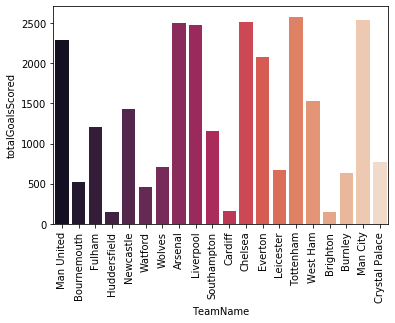

In [ ]:
#Total shot on target by Teams
totalShotsOnTargetPlot = sns.barplot(teamStats.TeamName, teamStats.totalShotsOnTarget,palette="rocket")
for item in totalShotsOnTargetPlot.get_xticklabels():
    item.set_rotation(90)

#Total scored by Teams
totalGoalsScoredPlot = sns.barplot(teamStats.TeamName, teamStats.totalGoalsScored,palette="rocket") 
for item in totalGoalsScoredPlot.get_xticklabels():
    item.set_rotation(90)
    
Remove_com_to_see_further_graph='''




totalShotsPlot = sns.barplot(teamStats.TeamName, teamStats.totalShots) 
for item in totalShotsPlot.get_xticklabels():
    item.set_rotation(90)
    

scoringRatioPlot = sns.barplot(teamStats.TeamName, teamStats.scoringRatio) 
for item in scoringRatioPlot.get_xticklabels():
    item.set_rotation(90)

'''




# **Cleanning Data**

Check if there are null data

In [ ]:
data.describe().round(2)

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
count,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00,3550.00
mean,1.57,1.18,0.69,0.52,14.19,11.24,6.10,4.83,10.68,11.22,6.05,4.79,1.48,1.78,0.06,0.09
std,1.33,1.16,0.84,0.73,5.50,4.69,3.48,2.92,3.40,3.58,3.13,2.74,1.20,1.29,0.25,0.30
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,0.00,10.00,8.00,4.00,3.00,8.00,9.00,4.00,3.00,1.00,1.00,0.00,0.00
50%,1.00,1.00,0.00,0.00,14.00,11.00,6.00,4.00,11.00,11.00,6.00,4.00,1.00,2.00,0.00,0.00
75%,2.00,2.00,1.00,1.00,17.00,14.00,8.00,6.00,13.00,14.00,8.00,6.00,2.00,3.00,0.00,0.00
max,9.00,7.00,5.00,5.00,43.00,30.00,24.00,20.00,24.00,26.00,19.00,19.00,7.00,9.00,2.00,2.00


In [ ]:
data.isnull().sum()

Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
Referee     0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

In [ ]:
teamStats.isnull().sum()

TeamName              0
totalGoalsScored      0
totalShotsOnTarget    0
totalGoalsAllowed     0
totalYellowCards      0
totalRedCards         0
totalFouls            0
totalCorners          0
totalShots            0
totalShotsAgainst     0
HSPG                  0
ASPG                  0
goalSaves             0
goalSavesPercent      0
scoringPercent        0
saveRatio             0
scoringRatio          0
dtype: int64

Visualising any trends in our data using Pandas (Scatter Matrices)

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
FTHG,1,-0.078,0.69,-0.059,0.29,-0.15,0.44,-0.097,-0.057,-0.046,0.054,-0.079,-0.11,-0.0051,-0.085,0.075
FTAG,-0.078,1,-0.073,0.69,-0.13,0.32,-0.1,0.45,0.022,-0.033,-0.088,0.051,0.12,-0.0063,0.12,-0.069
HTHG,0.69,-0.073,1,-0.068,0.11,-0.052,0.26,-0.052,-0.0084,-0.026,-0.051,-0.0016,-0.091,-0.02,-0.042,0.027
HTAG,-0.059,0.69,-0.068,1,-0.051,0.15,-0.056,0.28,0.019,-0.0054,-0.022,-0.027,0.1,0.0016,0.065,-0.028
HS,0.29,-0.13,0.11,-0.051,1,-0.39,0.66,-0.26,-0.14,-0.022,0.51,-0.32,-0.12,0.029,-0.11,0.11
AS,-0.15,0.32,-0.052,0.15,-0.39,1,-0.28,0.67,0.05,-0.09,-0.32,0.5,0.12,-0.07,0.12,-0.092
HST,0.44,-0.1,0.26,-0.056,0.66,-0.28,1,8.7e-05,-0.084,-0.029,0.36,-0.19,-0.14,0.014,-0.082,0.077
AST,-0.097,0.45,-0.052,0.28,-0.26,0.67,8.7e-05,1,0.046,-0.07,-0.18,0.34,0.067,-0.041,0.099,-0.062
HF,-0.057,0.022,-0.0084,0.019,-0.14,0.05,-0.084,0.046,1,0.097,-0.12,0.022,0.38,0.067,0.076,0.025
AF,-0.046,-0.033,-0.026,-0.0054,-0.022,-0.09,-0.029,-0.07,0.097,1,-0.012,-0.059,0.061,0.39,0.012,0.078


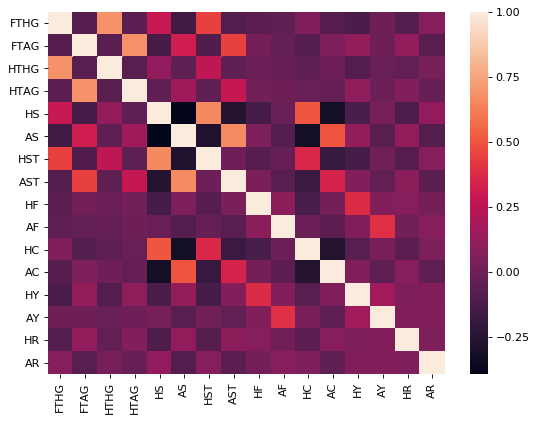

In [ ]:
import pandas as com

import seaborn as sns

%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')



# calculate the correlation matrix
corr = data.corr()
figsize=(10,10);
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns);

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "8pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '80px'),
                        ('font-size', '8pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

For team, we then separate feature set and targeted variable (Full Time Result : Home win / Draw / Away Win)

In [ ]:
filteredData = data[(data.HomeTeam.isin(team_name))]
data = filteredData[(filteredData.AwayTeam.isin(team_name))]

Z_all=data.drop(['Date','HTR','Referee','FTR'],1)
yyy=data['FTR']
print(yyy)

print(Z_all)

0       H
1       D
6       A
7       H
8       A
       ..
3540    A
3541    D
3543    H
3544    H
3546    D
Name: FTR, Length: 1498, dtype: object
         HomeTeam        AwayTeam  FTHG  FTAG  HTHG  ...  AC  HY  AY  HR  AR
0         Arsenal  Crystal Palace     2     1     1  ...   3   2   2   0   1
1       Leicester         Everton     2     2     1  ...   6   1   1   0   0
6        West Ham       Tottenham     0     1     0  ...   5   1   0   1   1
7       Liverpool     Southampton     2     1     1  ...   6   1   2   0   0
8       Newcastle        Man City     0     2     0  ...   3   1   5   0   0
...           ...             ...   ...   ...   ...  ...  ..  ..  ..  ..  ..
3540      Cardiff         Chelsea     1     2     1  ...   8   1   2   0   0
3541       Fulham  Crystal Palace     2     2     0  ...   4   3   1   0   0
3543    Liverpool       Newcastle     2     1     0  ...   2   1   3   0   2
3544     Man City        West Ham     2     0     1  ...   1   2   2   0   0
3546

And then standardising the data (center to the mean and component wise scale to unit variance)

In [ ]:
from sklearn.preprocessing import StandardScaler

Z_all.iloc[:,2:] = StandardScaler().fit_transform(Z_all.iloc[:,2:])



Our input data must be only continuous variable, so we convert any categorical variable into dummy variables.

In [ ]:
def preprocess_features(Z):
    output = pd.DataFrame(index = Z.index)
    for col, col_data in Z.iteritems():
        #Convert any categorical variable (here team names) to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
        output = output.join(col_data)
    
    return output

Check the result of the conversion

In [ ]:
#X_all = preprocess_features(X_all)
Z = preprocess_features(Z_all)

print(Z)

      HomeTeam_Arsenal  HomeTeam_Bournemouth  ...        HR        AR
0                    1                     0  ... -0.250749  3.103158
1                    0                     0  ... -0.250749 -0.297376
6                    0                     0  ...  3.661985  3.103158
7                    0                     0  ... -0.250749 -0.297376
8                    0                     0  ... -0.250749 -0.297376
...                ...                   ...  ...       ...       ...
3540                 0                     0  ... -0.250749 -0.297376
3541                 0                     0  ... -0.250749 -0.297376
3543                 0                     0  ... -0.250749  6.503692
3544                 0                     0  ... -0.250749 -0.297376
3546                 0                     0  ... -0.250749 -0.297376

[1498 rows x 56 columns]


In order to predict in a near future, the result of a confrontation when shuffle and split the dataset into a training and testing set.


In [ ]:
X_all = Z
y_all = yyy

print(X_all)
print(y_all)

      HomeTeam_Arsenal  HomeTeam_Bournemouth  ...        HR        AR
0                    1                     0  ... -0.250749  3.103158
1                    0                     0  ... -0.250749 -0.297376
6                    0                     0  ...  3.661985  3.103158
7                    0                     0  ... -0.250749 -0.297376
8                    0                     0  ... -0.250749 -0.297376
...                ...                   ...  ...       ...       ...
3540                 0                     0  ... -0.250749 -0.297376
3541                 0                     0  ... -0.250749 -0.297376
3543                 0                     0  ... -0.250749  6.503692
3544                 0                     0  ... -0.250749 -0.297376
3546                 0                     0  ... -0.250749 -0.297376

[1498 rows x 56 columns]
0       H
1       D
6       A
7       H
8       A
       ..
3540    A
3541    D
3543    H
3544    H
3546    D
Name: FTR, Length: 1498,

**Creating CSV for Spark**

In [ ]:

y_all2=y_all
y_all2 = y_all2.map({'H':1 , 'D':0 , 'A':2})

In [ ]:
sprktest=pd.concat([X_all, y_all2], axis=1)

In [ ]:
sprktest.to_csv('./DATA/Pre-processed-data/sprkdf.csv', index = None) 

# **Start ML in python**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.2,random_state=10,stratify=y_all,shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1198, 56)
(300, 56)
(1198,)
(300,)


In [ ]:
from time import time
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def train_classifier(clf, X_train, y_train):
    
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    print ("Trained model in {:.4f} seconds".format(end - start))
    
#Core training functions

def predict_labels(clf, features, target):
    #Makes predictions using a fit classifier based on F1 score.
    
    start = time()
    y_pred = clf.predict(features)
    end = time()

    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, average='macro'), sum(target == y_pred) / float(len(y_pred))

def train_predict(clf, X_train, y_train, X_test, y_test):
    #Train and predict using a classifer based on F1 score.
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    train_classifier(clf, X_train, y_train)
    
 #Results
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

When the apply 3 different models : Logistic Regression, SVC and KNeighborsClassifier

Random Forest

In [ ]:
#random forest
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
#fitting the model
clf_rf.fit(X_train, y_train)
#making predictions on the test set to compute ROC and precision
rf_predictions = clf_rf.predict(X_test)
rf_accuracy=round(accuracy_score(y_test, rf_predictions), 6)
print("accuracy_score in terms of random forest :",rf_accuracy)
models=pd.DataFrame([["random forest", rf_accuracy]], columns=["Model", "accuracy"])

accuracy_score in terms of random forest : 0.936667


Logistic Regression

In [ ]:
#logistic regression
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
#fitting the model
clf_lr.fit(X_train, y_train)
#making predictions on the test set to compute ROC and precision
lr_predictions = clf_lr.predict(X_test)
lr_accuracy=round(accuracy_score(y_test, lr_predictions), 6)
print("accuracy_score in terms of logistic regression :",lr_accuracy)
models=models.append(pd.Series(["logistic regression", lr_accuracy], index=models.columns), ignore_index=True)

accuracy_score in terms of logistic regression : 1.0


SVM

In [ ]:
#SVM
from sklearn.svm import SVC
clf_svm = SVC(degree=5, gamma='scale', random_state=42)
clf_svm.fit(X_train, y_train)
svm_predictions = clf_svm.predict(X_test)
svm_accuracy=round(accuracy_score(y_test, svm_predictions), 6)
print("accuracy_score in terms of SVM :",svm_accuracy)
models=models.append(pd.Series(["SVM", svm_accuracy], index=models.columns), ignore_index=True)

accuracy_score in terms of SVM : 0.976667


KNN

In [ ]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
knn_predictions = clf_knn.predict(X_test)
knn_accuracy=round(accuracy_score(y_test, knn_predictions), 6)
print("accuracy_score in terms of knn :",knn_accuracy)
models=models.append(pd.Series(["KNN", knn_accuracy], index=models.columns), ignore_index=True)

accuracy_score in terms of knn : 0.726667


XGBOOST

In [ ]:
#xgboost
from xgboost import XGBClassifier
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train, y_train)
xgb_predictions = clf_xgb.predict(X_test)
xgb_accuracy=round(accuracy_score(y_test, xgb_predictions), 6)
print("accuracy_score in terms of xgboost :",xgb_accuracy)
models=models.append(pd.Series(["XGB", xgb_accuracy], index=models.columns), ignore_index=True)

accuracy_score in terms of xgboost : 1.0


**Summary models**

In [ ]:
models=models.sort_values("accuracy", ascending = False)
models

,Model,accuracy
1,logistic regression,1.000000
4,XGB,1.000000
2,SVM,0.976667
0,random forest,0.936667
3,KNN,0.726667


**Feature importance**

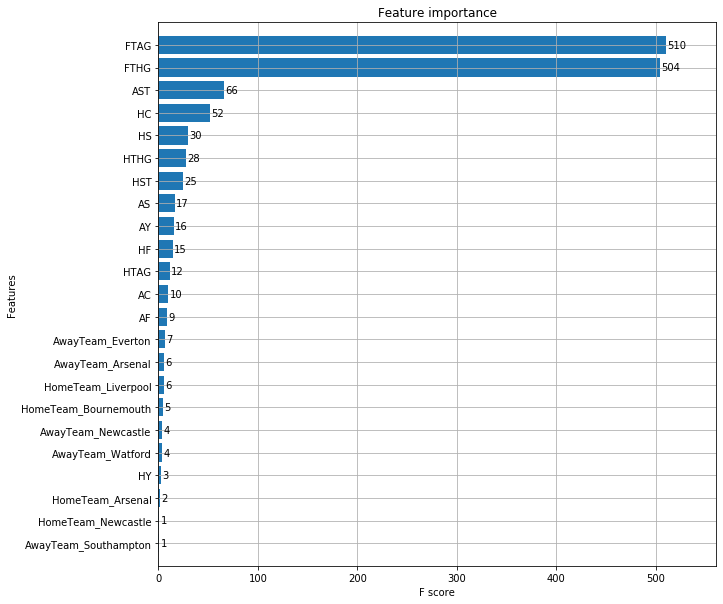

In [ ]:
from xgboost import plot_importance, plot_tree, to_graphviz
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(clf_xgb, height=.8, ax=ax)
plt.show()

**Confusion Matrix**

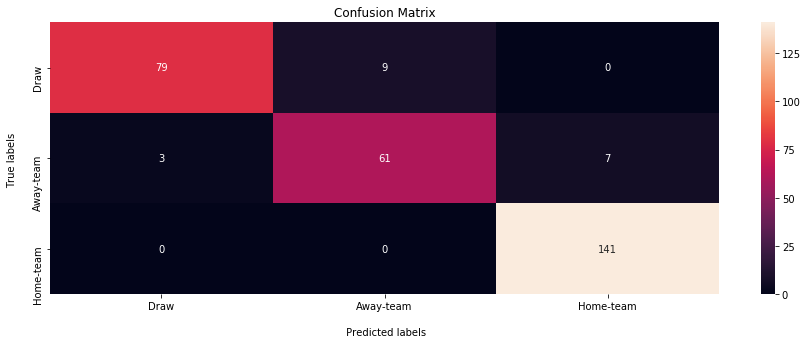

In [ ]:
from sklearn.metrics import confusion_matrix
plt.subplots(figsize=(15, 5))
ax = plt.subplot()
dt_conf_matrix = confusion_matrix(y_test,  clf_rf.predict(X_test) )
sns.heatmap(dt_conf_matrix, annot=True, ax = ax, fmt=''); 
ax.set_xlabel('\n Predicted labels');
ax.set_ylabel('True labels \n'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Draw', 'Away-team', 'Home-team']); 
ax.yaxis.set_ticklabels(['Draw', 'Away-team', 'Home-team']);

# **PYSPARK**

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

dataset = spark.read.csv('./DATA/Pre-processed-data/sprkdf.csv',inferSchema=True, header =True)

dataset.printSchema()

root
 |-- HomeTeam_Arsenal: integer (nullable = true)
 |-- HomeTeam_Bournemouth: integer (nullable = true)
 |-- HomeTeam_Brighton: integer (nullable = true)
 |-- HomeTeam_Burnley: integer (nullable = true)
 |-- HomeTeam_Cardiff: integer (nullable = true)
 |-- HomeTeam_Chelsea: integer (nullable = true)
 |-- HomeTeam_Crystal Palace: integer (nullable = true)
 |-- HomeTeam_Everton: integer (nullable = true)
 |-- HomeTeam_Fulham: integer (nullable = true)
 |-- HomeTeam_Huddersfield: integer (nullable = true)
 |-- HomeTeam_Leicester: integer (nullable = true)
 |-- HomeTeam_Liverpool: integer (nullable = true)
 |-- HomeTeam_Man City: integer (nullable = true)
 |-- HomeTeam_Man United: integer (nullable = true)
 |-- HomeTeam_Newcastle: integer (nullable = true)
 |-- HomeTeam_Southampton: integer (nullable = true)
 |-- HomeTeam_Tottenham: integer (nullable = true)
 |-- HomeTeam_Watford: integer (nullable = true)
 |-- HomeTeam_West Ham: integer (nullable = true)
 |-- HomeTeam_Wolves: integer (

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType
dataset=dataset.select(*(col(c).cast(DoubleType()).alias(c) for c in dataset.columns))

In [ ]:
#Input all the features in one vector column
assembler = VectorAssembler(inputCols=['HomeTeam_Arsenal','HomeTeam_Bournemouth','HomeTeam_Brighton','HomeTeam_Burnley','HomeTeam_Cardiff','HomeTeam_Chelsea','HomeTeam_Crystal Palace','HomeTeam_Everton','HomeTeam_Fulham','HomeTeam_Huddersfield','HomeTeam_Leicester','HomeTeam_Liverpool','HomeTeam_Man City','HomeTeam_Man United','HomeTeam_Newcastle','HomeTeam_Southampton','HomeTeam_Tottenham','HomeTeam_Watford','HomeTeam_West Ham','HomeTeam_Wolves','AwayTeam_Arsenal','AwayTeam_Bournemouth','AwayTeam_Brighton','AwayTeam_Burnley','AwayTeam_Cardiff','AwayTeam_Chelsea','AwayTeam_Crystal Palace','AwayTeam_Everton','AwayTeam_Fulham','AwayTeam_Huddersfield','AwayTeam_Leicester','AwayTeam_Liverpool','AwayTeam_Man City','AwayTeam_Man United','AwayTeam_Newcastle','AwayTeam_Southampton','AwayTeam_Tottenham','AwayTeam_Watford','AwayTeam_West Ham','AwayTeam_Wolves','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR'], outputCol = 'Attributes')

output = assembler.transform(dataset)

#Input vs Output
finalized_data = output.select('Attributes','FTR')

finalized_data.printSchema()

root
 |-- Attributes: vector (nullable = true)
 |-- FTR: double (nullable = true)



In [ ]:
# Spark support only two columns during training one for features and second one is labels
# Vector Assembler is used to assemble all the features used for training 
# Class in the label where to train a Classification model for estimating the 
# bill is counterfeit or not
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['HomeTeam_Arsenal','HomeTeam_Bournemouth','HomeTeam_Brighton','HomeTeam_Burnley','HomeTeam_Cardiff','HomeTeam_Chelsea','HomeTeam_Crystal Palace','HomeTeam_Everton','HomeTeam_Fulham','HomeTeam_Huddersfield','HomeTeam_Leicester','HomeTeam_Liverpool','HomeTeam_Man City','HomeTeam_Man United','HomeTeam_Newcastle','HomeTeam_Southampton','HomeTeam_Tottenham','HomeTeam_Watford','HomeTeam_West Ham','HomeTeam_Wolves','AwayTeam_Arsenal','AwayTeam_Bournemouth','AwayTeam_Brighton','AwayTeam_Burnley','AwayTeam_Cardiff','AwayTeam_Chelsea','AwayTeam_Crystal Palace','AwayTeam_Everton','AwayTeam_Fulham','AwayTeam_Huddersfield','AwayTeam_Leicester','AwayTeam_Liverpool','AwayTeam_Man City','AwayTeam_Man United','AwayTeam_Newcastle','AwayTeam_Southampton','AwayTeam_Tottenham','AwayTeam_Watford','AwayTeam_West Ham','AwayTeam_Wolves','FTHG','FTAG','HTHG','HTAG','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR'], outputCol = 'features')
Counterfeit_df = vectorAssembler.transform(dataset)
Counterfeit_df= Counterfeit_df.select(['features', 'FTR'])
Counterfeit_df.show(3)

+--------------------+---+
|            features|FTR|
+--------------------+---+
|(56,[0,26,40,41,4...|1.0|
|(56,[10,27,40,41,...|0.0|
|(56,[18,36,40,41,...|2.0|
+--------------------+---+
only showing top 3 rows



In [ ]:
# Splitting data into training and testing 80% training and 20% testing
weights = [.8, .2]
#seed = 42 # seed=0L
rawTrainData, rawValidationData = Counterfeit_df.randomSplit(weights)

In [ ]:
rawValidationData.printSchema()


root
 |-- features: vector (nullable = true)
 |-- FTR: double (nullable = true)



In [ ]:
# training the logistic regression madel
from pyspark.ml.classification import LogisticRegression
lr =  LogisticRegression(featuresCol = 'features', labelCol='FTR', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(rawTrainData)


In [ ]:
# Testing the trained logistic regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
lr_predictions = lr_model.transform(rawValidationData)
lr_predictions.select("prediction","FTR","features").show(5)
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="FTR", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lr_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

+----------+---+--------------------+
|prediction|FTR|            features|
+----------+---+--------------------+
|       1.0|0.0|(56,[0,25,40,41,4...|
|       1.0|2.0|(56,[0,25,40,41,4...|
|       1.0|1.0|(56,[0,25,40,41,4...|
|       1.0|0.0|(56,[0,27,40,41,4...|
|       1.0|1.0|(56,[0,27,40,41,4...|
+----------+---+--------------------+
only showing top 5 rows

Test Error = 0.492795 
Accuracy = 0.507205 


In [ ]:
# Training and testing the Random Forest model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol='FTR')
rf_model = rf.fit(rawTrainData)
rf_predictions = rf_model.transform(rawValidationData)
rf_predictions.select('prediction', 'FTR', 'features').show(10)
valuator = MulticlassClassificationEvaluator(
    labelCol="FTR", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print("Test Error = %g " % (1.0 - accuracy))
print("Accuracy = %g " % ( accuracy))

+----------+---+--------------------+
|prediction|FTR|            features|
+----------+---+--------------------+
|       0.0|0.0|(56,[0,25,40,41,4...|
|       2.0|2.0|(56,[0,25,40,41,4...|
|       1.0|1.0|(56,[0,25,40,41,4...|
|       0.0|0.0|(56,[0,27,40,41,4...|
|       1.0|1.0|(56,[0,27,40,41,4...|
|       0.0|0.0|(56,[0,28,40,41,4...|
|       1.0|1.0|(56,[0,28,40,41,4...|
|       1.0|1.0|(56,[0,29,40,41,4...|
|       1.0|1.0|(56,[0,30,40,41,4...|
|       2.0|2.0|(56,[0,31,40,41,4...|
+----------+---+--------------------+
only showing top 10 rows

Test Error = 0.146974 
Accuracy = 0.853026 


# **Test For a New Data**

In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
model.predict(X_test)

array(['H', 'A', 'H', 'D', 'D', 'A', 'H', 'D', 'H', 'H', 'H', 'H', 'A',
       'H', 'H', 'D', 'H', 'H', 'A', 'A', 'H', 'H', 'D', 'D', 'H', 'A',
       'A', 'A', 'D', 'H', 'D', 'H', 'H', 'H', 'A', 'H', 'A', 'A', 'D',
       'A', 'A', 'A', 'D', 'H', 'H', 'A', 'D', 'H', 'A', 'H', 'D', 'H',
       'A', 'H', 'D', 'A', 'H', 'A', 'A', 'D', 'A', 'H', 'D', 'A', 'H',
       'H', 'H', 'A', 'H', 'H', 'H', 'H', 'A', 'D', 'D', 'A', 'H', 'A',
       'A', 'A', 'A', 'A', 'H', 'D', 'A', 'H', 'H', 'H', 'D', 'A', 'D',
       'D', 'H', 'A', 'H', 'H', 'D', 'A', 'D', 'A', 'A', 'A', 'H', 'H',
       'H', 'A', 'D', 'A', 'H', 'H', 'H', 'H', 'A', 'A', 'H', 'H', 'H',
       'H', 'H', 'H', 'H', 'A', 'D', 'H', 'A', 'H', 'H', 'A', 'D', 'H',
       'H', 'D', 'H', 'A', 'H', 'H', 'D', 'H', 'H', 'D', 'D', 'H', 'H',
       'H', 'D', 'H', 'H', 'H', 'A', 'A', 'A', 'A', 'H', 'H', 'D', 'D',
       'H', 'H', 'H', 'H', 'H', 'A', 'H', 'A', 'D', 'A', 'D', 'H', 'H',
       'A', 'D', 'H', 'H', 'H', 'A', 'A', 'H', 'A', 'A', 'D', 'H

We then wanted to observe predicted probabilities

In [ ]:
predictedProbability = model.predict_proba(X_test)
predictedProbability = pd.DataFrame(predictedProbability, columns=['Away Team','Draw','Home Team'])

display((predictedProbability*100 ))

,Away Team,Draw,Home Team
0,0.0,40.0,60.0
1,80.0,20.0,0.0
2,0.0,20.0,80.0
3,0.0,80.0,20.0
4,20.0,40.0,40.0
...,...,...,...
295,60.0,40.0,0.0
296,0.0,20.0,80.0
297,0.0,20.0,80.0
298,100.0,0.0,0.0


Since we are able to make predictions, we want now to test it on match fixtures for the season 18-19

In [ ]:
fixtures = pd.read_csv('./DATA/Fixtures/fixtures.csv')
fixtures = fixtures.drop(['Round Number','Date','Location','Result'],1)
fixtures.columns = ['HomeTeam','AwayTeam']
fixtures['FTHG']= 0
fixtures['FTAG'] =0 
fixtures['HTHG'] = 0
fixtures['HTAG'] = 0
fixtures['HS'] = 0
fixtures['AS'] = 0
fixtures['HST'] = 0
fixtures['AST'] = 0
fixtures['HF'] = 0
fixtures['AF'] = 0
fixtures['HC'] = 0
fixtures['AC'] = 0
fixtures['HY'] = 0
fixtures['AY'] = 0
fixtures['HR'] = 0
fixtures['AR'] = 0

In [ ]:
display(fixtures.head(15))

,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,Man Utd,Leicester,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Newcastle,Spurs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Bournemouth,Cardiff,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Fulham,Crystal Palace,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Huddersfield,Chelsea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Watford,Brighton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Wolves,Everton,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Liverpool,West Ham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Southampton,Burnley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Arsenal,Man City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Our input data must be only continuous variable, so again we convert any categorical variable into dummy variables.

In [ ]:
preprocessedFixtures = preprocess_features(fixtures)

In [ ]:
preprocessedFixtures

,HomeTeam_Arsenal,HomeTeam_Bournemouth,HomeTeam_Brighton,HomeTeam_Burnley,HomeTeam_Cardiff,HomeTeam_Chelsea,HomeTeam_Crystal Palace,HomeTeam_Everton,HomeTeam_Fulham,HomeTeam_Huddersfield,HomeTeam_Leicester,HomeTeam_Liverpool,HomeTeam_Man City,HomeTeam_Man Utd,HomeTeam_Newcastle,HomeTeam_Southampton,HomeTeam_Spurs,HomeTeam_Watford,HomeTeam_West Ham,HomeTeam_Wolves,AwayTeam_Arsenal,AwayTeam_Bournemouth,AwayTeam_Brighton,AwayTeam_Burnley,AwayTeam_Cardiff,AwayTeam_Chelsea,AwayTeam_Crystal Palace,AwayTeam_Everton,AwayTeam_Fulham,AwayTeam_Huddersfield,AwayTeam_Leicester,AwayTeam_Liverpool,AwayTeam_Man City,AwayTeam_Man Utd,AwayTeam_Newcastle,AwayTeam_Southampton,AwayTeam_Spurs,AwayTeam_Watford,AwayTeam_West Ham,AwayTeam_Wolves,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
376,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
377,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
378,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
model.predict(preprocessedFixtures)

array(['H', 'D', 'D', 'H', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'A',
       'H', 'D', 'D', 'D', 'H', 'D', 'D', 'D', 'D', 'D', 'H', 'D', 'D',
       'H', 'D', 'A', 'H', 'D', 'D', 'H', 'D', 'D', 'D', 'H', 'D', 'D',
       'D', 'D', 'D', 'D', 'H', 'H', 'D', 'D', 'D', 'D', 'D', 'D', 'D',
       'D', 'D', 'D', 'D', 'H', 'D', 'A', 'D', 'D', 'D', 'H', 'D', 'H',
       'D', 'D', 'D', 'D', 'D', 'D', 'D', 'A', 'D', 'H', 'H', 'H', 'D',
       'D', 'D', 'D', 'D', 'H', 'H', 'D', 'D', 'D', 'D', 'D', 'A', 'A',
       'D', 'D', 'H', 'D', 'D', 'D', 'D', 'H', 'H', 'D', 'D', 'D', 'D',
       'D', 'D', 'D', 'H', 'H', 'H', 'D', 'D', 'D', 'D', 'D', 'D', 'H',
       'D', 'D', 'D', 'D', 'H', 'D', 'H', 'D', 'D', 'H', 'D', 'A', 'D',
       'A', 'D', 'D', 'D', 'H', 'D', 'D', 'D', 'D', 'D', 'D', 'H', 'D',
       'H', 'D', 'D', 'D', 'D', 'H', 'H', 'D', 'D', 'D', 'D', 'H', 'D',
       'D', 'D', 'A', 'D', 'D', 'D', 'D', 'H', 'H', 'D', 'D', 'D', 'H',
       'D', 'D', 'D', 'D', 'D', 'D', 'H', 'D', 'D', 'D', 'D', 'A

We are adding a new column containing predicted result.

In [ ]:
fixtures['Result Predicted'] = model.predict(preprocessedFixtures)

For better understanding, we remove unnecesserary features.

In [ ]:
Result = fixtures.drop(['FTHG','FTAG','HTHG','HTAG','HS','AS','HST','HF','AF','HY',
                        'AY','HR','AR','HC','AC','AST','HC','AC'],1)
Result.head()

,HomeTeam,AwayTeam,Result Predicted
0,Man Utd,Leicester,H
1,Newcastle,Spurs,D
2,Bournemouth,Cardiff,D
3,Fulham,Crystal Palace,H
4,Huddersfield,Chelsea,D


Retrieving probability for each labels and for each match

In [ ]:
fixturePredictedProbability = model.predict_proba(preprocessedFixtures) *100
fixturePredictedProbability = pd.DataFrame(fixturePredictedProbability, columns=['Away win %','Draw %','Home win %'])

display(fixturePredictedProbability)

,Away win %,Draw %,Home win %
0,20.0,20.0,60.0
1,20.0,60.0,20.0
2,0.0,60.0,40.0
3,0.0,40.0,60.0
4,20.0,40.0,40.0
...,...,...,...
375,0.0,60.0,40.0
376,0.0,40.0,60.0
377,0.0,60.0,40.0
378,0.0,40.0,60.0


And combining both previous results to obtain a clear overview on the predicted results

In [ ]:
final = pd.concat([Result, fixturePredictedProbability], axis = 1)
final.head(30)

,HomeTeam,AwayTeam,Result Predicted,Away win %,Draw %,Home win %
0,Man Utd,Leicester,H,20.0,20.0,60.0
1,Newcastle,Spurs,D,20.0,60.0,20.0
2,Bournemouth,Cardiff,D,0.0,60.0,40.0
3,Fulham,Crystal Palace,H,0.0,40.0,60.0
4,Huddersfield,Chelsea,D,20.0,40.0,40.0
5,Watford,Brighton,D,20.0,40.0,40.0
6,Wolves,Everton,D,0.0,60.0,40.0
7,Liverpool,West Ham,D,0.0,60.0,40.0
8,Southampton,Burnley,D,0.0,60.0,40.0
9,Arsenal,Man City,D,20.0,40.0,40.0


We export our predicted results into a CSV file

And combine it with the original fixtures file, to recover such information as league round number, date ofthe confrontation and the location of the match

In [ ]:
readFixtures = pd.read_csv('./DATA/Fixtures/fixtures.csv')
exportToFixtures = final.drop(['HomeTeam','AwayTeam'],1)

PredictedResultWithFixtureData = pd.concat([readFixtures,exportToFixtures], axis = 1)
PredictedResultWithFixtureData.to_csv('./DATA/Final-Results/Predicted_Result_withFix.csv')


display(PredictedResultWithFixtureData.tail(20))

,Round Number,Date,Location,Home Team,Away Team,Result,Result Predicted,Away win %,Draw %,Home win %
360,37,04/05/2019 19:45,Emirates Stadium,Arsenal,Brighton,NaN,D,20.0,40.0,40.0
361,37,04/05/2019 19:45,Vitality Stadium,Bournemouth,Spurs,NaN,D,0.0,80.0,20.0
362,37,04/05/2019 19:45,Cardiff City Stadium,Cardiff,Crystal Palace,NaN,H,0.0,40.0,60.0
363,37,04/05/2019 19:45,Stamford Bridge,Chelsea,Watford,NaN,D,0.0,80.0,20.0
364,37,04/05/2019 19:45,Goodison Park,Everton,Burnley,NaN,D,0.0,60.0,40.0
365,37,04/05/2019 19:45,John Smith's Stadium,Huddersfield,Man Utd,NaN,D,0.0,80.0,20.0
366,37,04/05/2019 19:45,Etihad Stadium,Man City,Leicester,NaN,D,20.0,40.0,40.0
367,37,04/05/2019 19:45,St. James' Park,Newcastle,Liverpool,NaN,D,20.0,60.0,20.0
368,37,04/05/2019 19:45,London Stadium,West Ham,Southampton,NaN,H,0.0,40.0,60.0
369,37,04/05/2019 19:45,Molineux Stadium,Wolves,Fulham,NaN,H,0.0,40.0,60.0
